In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
spark = SparkSession.builder \
    .appName("ShoppingTrendsEDA") \
    .master("local[*]") \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/10/25 21:10:22 WARN Utils: Your hostname, codespaces-2c848d, resolves to a loopback address: 127.0.0.1; using 10.0.0.169 instead (on interface eth0)
25/10/25 21:10:22 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/25 21:10:23 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
df = spark.read.csv("../data/shopping_trends.csv", 
                    header=True, inferSchema=True)
print(f"Loaded {df.count()} rows")

Loaded 3900 rows


In [6]:
df.printSchema()
df.show(5)

root
 |-- Customer ID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Item Purchased: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Purchase Amount (USD): integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Color: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- Review Rating: double (nullable = true)
 |-- Subscription Status: string (nullable = true)
 |-- Shipping Type: string (nullable = true)
 |-- Discount Applied: string (nullable = true)
 |-- Promo Code Used: string (nullable = true)
 |-- Previous Purchases: integer (nullable = true)
 |-- Payment Method: string (nullable = true)
 |-- Frequency of Purchases: string (nullable = true)

+-----------+---+------+--------------+--------+---------------------+-------------+----+---------+------+-------------+-------------------+-------------+----------------+---------------+-----------

In [4]:
df.createOrReplaceTempView("shopping")

In [5]:
spark.sql("""
    SELECT Category, COUNT(*) as count
    FROM shopping
    GROUP BY Category
    ORDER BY count DESC
""").show()

+-----------+-----+
|   Category|count|
+-----------+-----+
|   Clothing| 1737|
|Accessories| 1240|
|   Footwear|  599|
|  Outerwear|  324|
+-----------+-----+



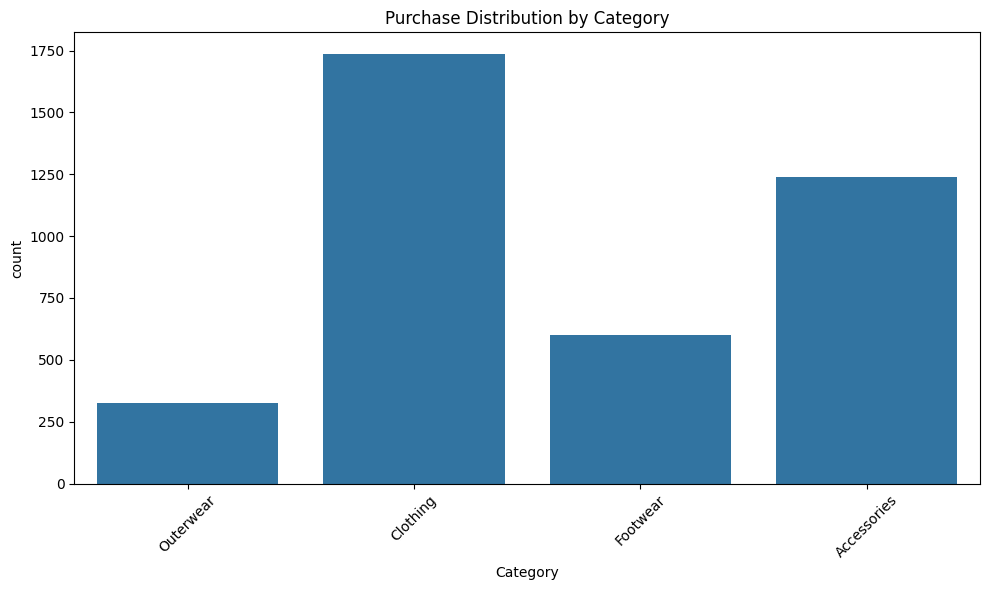

In [6]:
category_data = spark.sql("""
    SELECT Category, COUNT(*) as count
    FROM shopping
    GROUP BY Category
""").toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(data=category_data, x='Category', y='count')
plt.title('Purchase Distribution by Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../output/figures/category_distribution.png')
plt.show()

REVENUE ANALYSIS

Overall Revenue Metrics:
-RECORD 0--------------------
 total_revenue      | 233081 
 avg_transaction    | 59.76  
 min_transaction    | 20     
 max_transaction    | 100    
 stddev_transaction | 23.69  
 unique_customers   | 3900   
 total_transactions | 3900   


Revenue by Category:
+-----------+-----------------+-------------+---------------+
|Category   |transaction_count|total_revenue|avg_transaction|
+-----------+-----------------+-------------+---------------+
|Clothing   |1737             |104264       |60.03          |
|Accessories|1240             |74200        |59.84          |
|Footwear   |599              |36093        |60.26          |
|Outerwear  |324              |18524        |57.17          |
+-----------+-----------------+-------------+---------------+



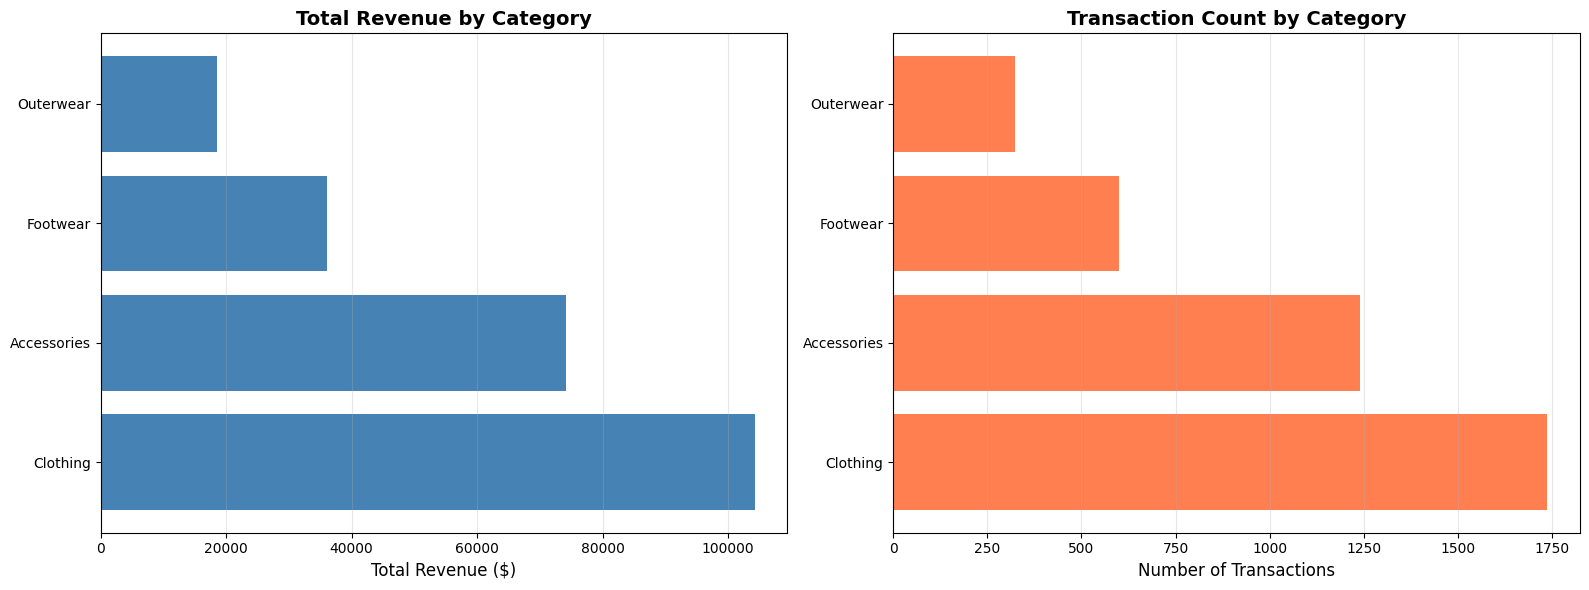

✓ Visualization saved: output/figures/category_analysis.png


In [7]:
print("=" * 80)
print("REVENUE ANALYSIS")
print("=" * 80)

# Total revenue and key metrics
revenue_metrics = spark.sql("""
    SELECT 
        ROUND(SUM(`Purchase Amount (USD)`), 2) as total_revenue,
        ROUND(AVG(`Purchase Amount (USD)`), 2) as avg_transaction,
        ROUND(MIN(`Purchase Amount (USD)`), 2) as min_transaction,
        ROUND(MAX(`Purchase Amount (USD)`), 2) as max_transaction,
        ROUND(STDDEV(`Purchase Amount (USD)`), 2) as stddev_transaction,
        COUNT(DISTINCT `Customer ID`) as unique_customers,
        COUNT(*) as total_transactions
    FROM shopping
""")

print("\nOverall Revenue Metrics:")
revenue_metrics.show(vertical=True)

# Revenue by category
print("\nRevenue by Category:")
category_revenue_spark = spark.sql("""
    SELECT 
        Category,
        COUNT(*) as transaction_count,
        ROUND(SUM(`Purchase Amount (USD)`), 2) as total_revenue,
        ROUND(AVG(`Purchase Amount (USD)`), 2) as avg_transaction
    FROM shopping
    GROUP BY Category
    ORDER BY total_revenue DESC
""")
category_revenue_spark.show(truncate=False)

# Convert to pandas for visualization
category_revenue = category_revenue_spark.toPandas()

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Total Revenue by Category
axes[0].barh(category_revenue['Category'], category_revenue['total_revenue'], color='steelblue')
axes[0].set_xlabel('Total Revenue ($)', fontsize=12)
axes[0].set_title('Total Revenue by Category', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Transaction Count by Category
axes[1].barh(category_revenue['Category'], category_revenue['transaction_count'], color='coral')
axes[1].set_xlabel('Number of Transactions', fontsize=12)
axes[1].set_title('Transaction Count by Category', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../output/figures/category_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved: output/figures/category_analysis.png")

CUSTOMER DEMOGRAPHICS ANALYSIS
+---------+--------------+------------+
|age_group|customer_count|avg_purchase|
+---------+--------------+------------+
| Under 20|           150|       60.53|
|    20-29|           728|        60.2|
|    30-39|           724|       60.14|
|    40-49|           739|       58.49|
|    50-59|           771|       60.33|
|      60+|           788|       59.51|
+---------+--------------+------------+

+------+---------------+------------+-----------+
|Gender|total_purchases|avg_purchase|total_spent|
+------+---------------+------------+-----------+
|Male  |2652           |59.54       |157890     |
|Female|1248           |60.25       |75191      |
+------+---------------+------------+-----------+



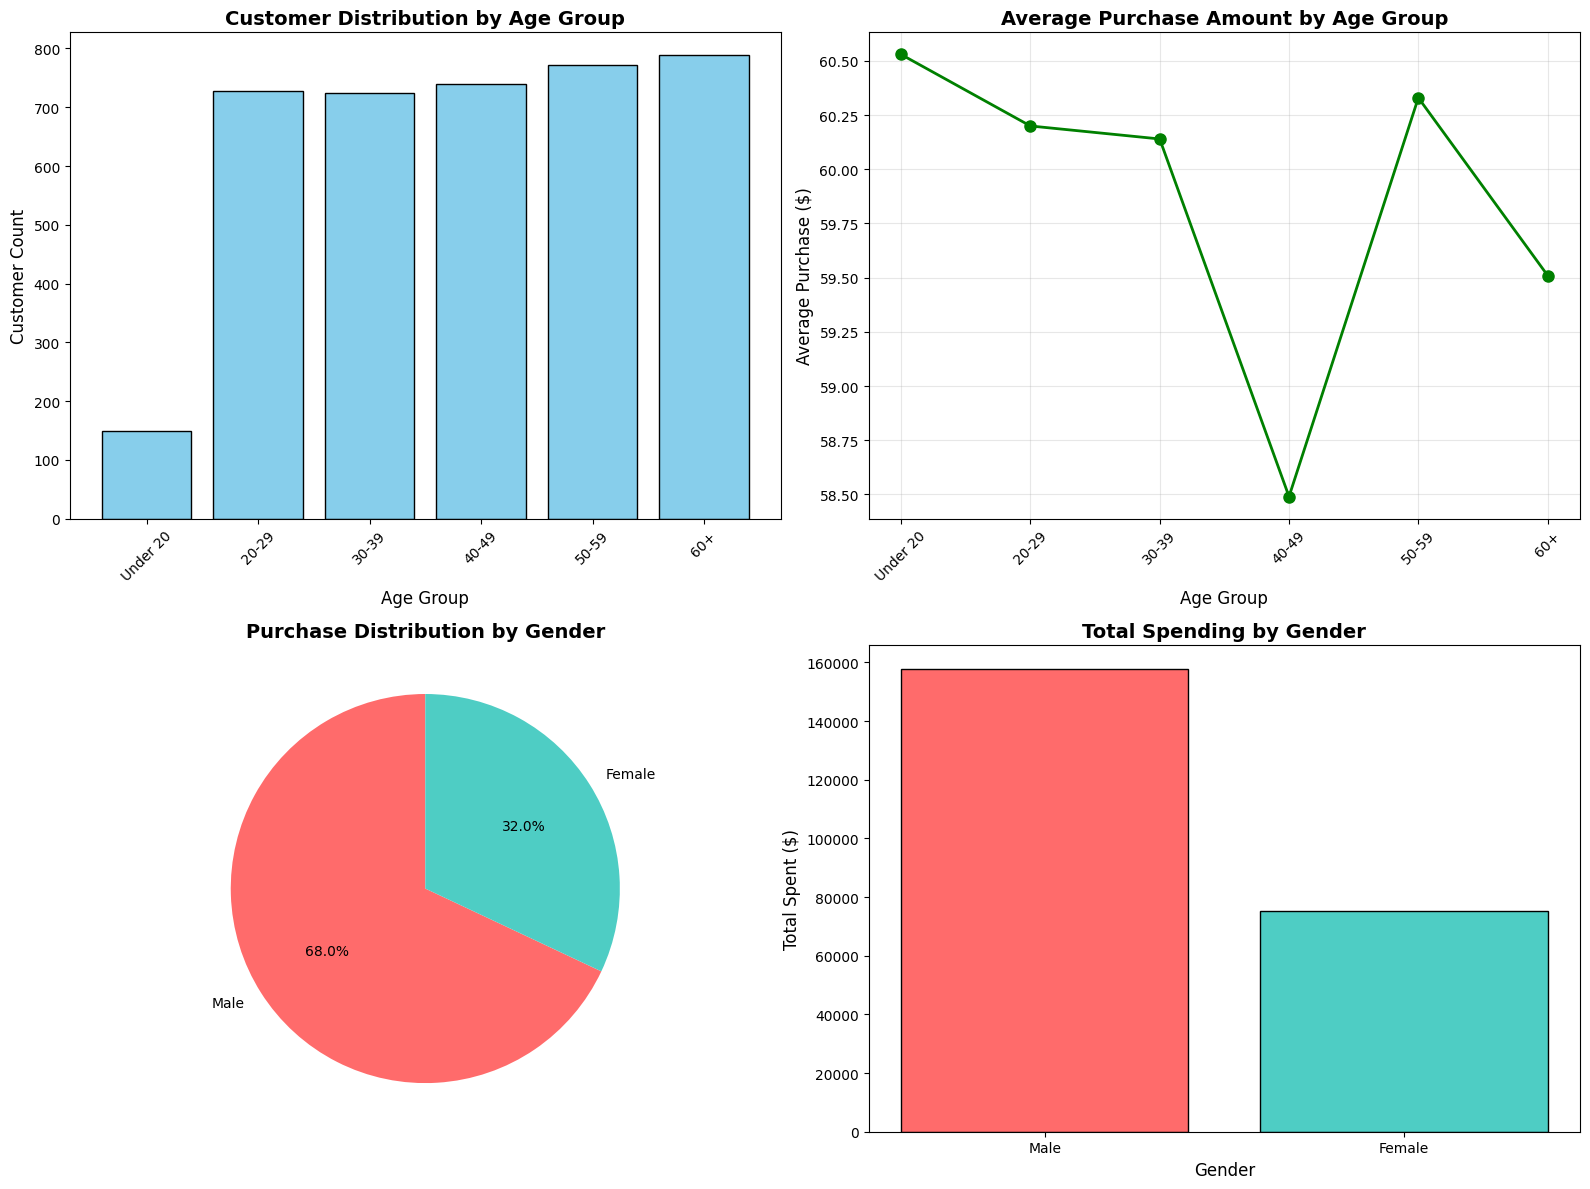

✓ Visualization saved: output/figures/demographics_analysis.png


In [8]:
print("=" * 80)
print("CUSTOMER DEMOGRAPHICS ANALYSIS")
print("=" * 80)

# Age distribution with bins
age_distribution_spark = spark.sql("""
    SELECT 
        CASE 
            WHEN Age < 20 THEN 'Under 20'
            WHEN Age BETWEEN 20 AND 29 THEN '20-29'
            WHEN Age BETWEEN 30 AND 39 THEN '30-39'
            WHEN Age BETWEEN 40 AND 49 THEN '40-49'
            WHEN Age BETWEEN 50 AND 59 THEN '50-59'
            WHEN Age >= 60 THEN '60+'
        END as age_group,
        COUNT(*) as customer_count,
        ROUND(AVG(`Purchase Amount (USD)`), 2) as avg_purchase
    FROM shopping
    GROUP BY age_group
    ORDER BY 
        CASE age_group
            WHEN 'Under 20' THEN 1
            WHEN '20-29' THEN 2
            WHEN '30-39' THEN 3
            WHEN '40-49' THEN 4
            WHEN '50-59' THEN 5
            WHEN '60+' THEN 6
        END
""")
age_distribution_spark.show()

age_distribution = age_distribution_spark.toPandas()

# Gender-based purchasing patterns
gender_analysis_spark = spark.sql("""
    SELECT 
        Gender,
        COUNT(*) as total_purchases,
        ROUND(AVG(`Purchase Amount (USD)`), 2) as avg_purchase,
        ROUND(SUM(`Purchase Amount (USD)`), 2) as total_spent
    FROM shopping
    GROUP BY Gender
    ORDER BY total_spent DESC
""")
gender_analysis_spark.show(truncate=False)

gender_analysis = gender_analysis_spark.toPandas()

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Age Distribution
axes[0, 0].bar(age_distribution['age_group'], age_distribution['customer_count'], color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('Age Group', fontsize=12)
axes[0, 0].set_ylabel('Customer Count', fontsize=12)
axes[0, 0].set_title('Customer Distribution by Age Group', fontsize=14, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Average Purchase by Age
axes[0, 1].plot(age_distribution['age_group'], age_distribution['avg_purchase'], 
                marker='o', linewidth=2, markersize=8, color='green')
axes[0, 1].set_xlabel('Age Group', fontsize=12)
axes[0, 1].set_ylabel('Average Purchase ($)', fontsize=12)
axes[0, 1].set_title('Average Purchase Amount by Age Group', fontsize=14, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Gender Distribution
colors = ['#FF6B6B', '#4ECDC4']
axes[1, 0].pie(gender_analysis['total_purchases'], labels=gender_analysis['Gender'], 
               autopct='%1.1f%%', startangle=90, colors=colors)
axes[1, 0].set_title('Purchase Distribution by Gender', fontsize=14, fontweight='bold')

# Plot 4: Gender Spending
axes[1, 1].bar(gender_analysis['Gender'], gender_analysis['total_spent'], color=colors, edgecolor='black')
axes[1, 1].set_xlabel('Gender', fontsize=12)
axes[1, 1].set_ylabel('Total Spent ($)', fontsize=12)
axes[1, 1].set_title('Total Spending by Gender', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../output/figures/demographics_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization saved: output/figures/demographics_analysis.png")